In [2]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Input, GlobalAveragePooling2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

In [3]:
import os

# Assuming the dataset folder is located in the root directory of Google Drive
dataset_folder_path = r'C:\Users\ilfas\OneDrive\Documents\college\dm proj\df\df\real_vs_fake\real-vs-fake'
os.chdir(dataset_folder_path)

In [4]:
train_dir = os.path.join(dataset_folder_path, 'train')
valid_dir = os.path.join(dataset_folder_path, 'valid')
test_dir = os.path.join(dataset_folder_path, 'test')

In [5]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [6]:
# Define the paths to train, valid, and test directories
train_dir = os.path.join(dataset_folder_path, 'train')
valid_dir = os.path.join(dataset_folder_path, 'valid')
test_dir = os.path.join(dataset_folder_path, 'test')

# List subfolders and sort them
train_subfolders = sorted(os.listdir(train_dir))
valid_subfolders = sorted(os.listdir(valid_dir))
test_subfolders = sorted(os.listdir(test_dir))

# Print the sorted subfolders
print("Train_dir Subfolders: ", train_subfolders)
print("Valid_dir Subfolders: ", valid_subfolders)
print("Test_dir Subfolders: ", test_subfolders)

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


## EXPLORATORY ANALYSIS

In [7]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(dataset_folder_path): #iterate on each train, valid and test folder
    for label in os.listdir(dataset_folder_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(dataset_folder_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [8]:
images_df = pd.DataFrame(images_df)
images_df

,folder,image_path,label
0,test,C:\Users\ilfas\OneDrive\Documents\college\dm p...,fake
1,test,C:\Users\ilfas\OneDrive\Documents\college\dm p...,fake
2,test,C:\Users\ilfas\OneDrive\Documents\college\dm p...,fake
3,test,C:\Users\ilfas\OneDrive\Documents\college\dm p...,fake
4,test,C:\Users\ilfas\OneDrive\Documents\college\dm p...,fake
...,...,...,...
6995,valid,C:\Users\ilfas\OneDrive\Documents\college\dm p...,real
6996,valid,C:\Users\ilfas\OneDrive\Documents\college\dm p...,real
6997,valid,C:\Users\ilfas\OneDrive\Documents\college\dm p...,real
6998,valid,C:\Users\ilfas\OneDrive\Documents\college\dm p...,real


In [9]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

## Data Augmentation

In [10]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape)
)


image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [11]:
#changing batch size from 64 to 32
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32, 
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 5000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

# Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

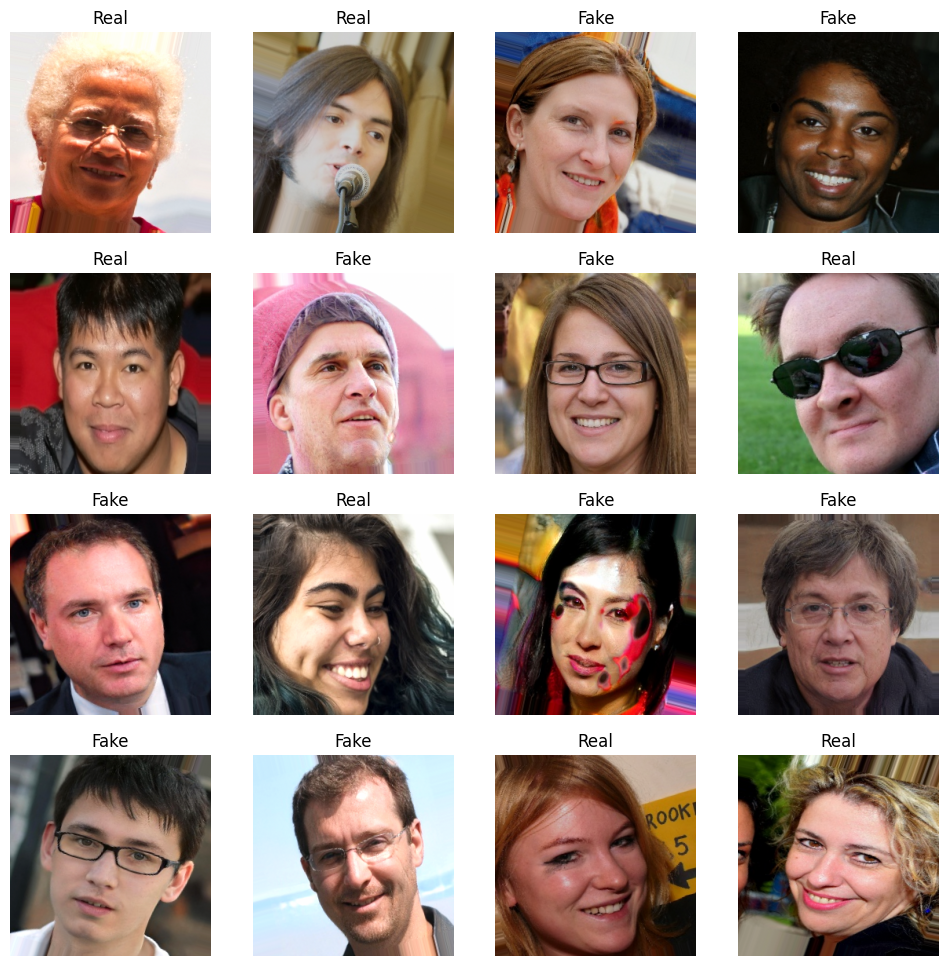

In [23]:
img,lbl = next(train_ds)
plot_images(img,lbl)

Histogram of Pixel Intensities:

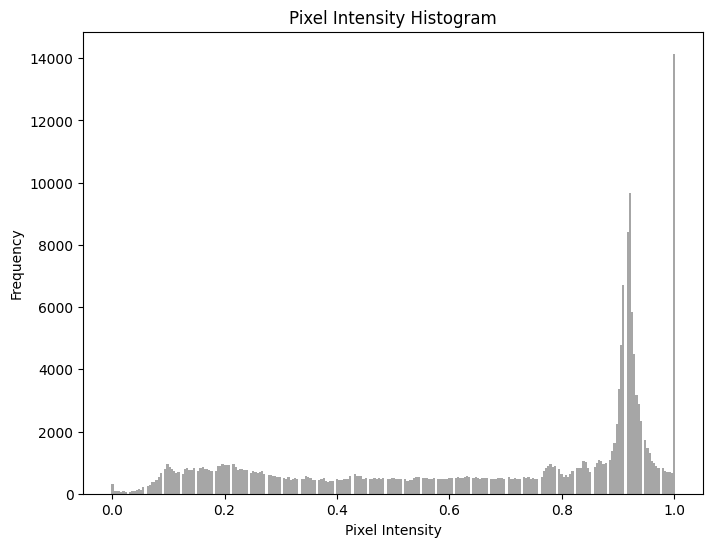

In [24]:
def plot_pixel_histogram(image):
    plt.figure(figsize=(8, 6))
    plt.hist(image.ravel(), bins=256, color='gray', alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Histogram')
    plt.show()

# Plot histogram 
sample_image = img[0] 
plot_pixel_histogram(sample_image)


In [25]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.58792704 0.5884693  0.54875714]
  [0.5885712  0.58834946 0.5492181 ]
  [0.5882029  0.58877015 0.54492086]
  ...
  [0.49763316 0.47052816 0.3847457 ]
  [0.49388552 0.46646282 0.38415664]
  [0.49441704 0.46721545 0.38827422]]

 [[0.5799875  0.5799998  0.5525601 ]
  [0.58437675 0.58460903 0.5529651 ]
  [0.58473575 0.58462137 0.5530571 ]
  ...
  [0.49760294 0.47069198 0.38450265]
  [0.49386126 0.46648204 0.38400036]
  [0.49468213 0.46615806 0.3881153 ]]

 [[0.5803846  0.5800097  0.5533161 ]
  [0.58045477 0.5805562  0.55364877]
  [0.5807258  0.58032465 0.552891  ]
  ...
  [0.49844015 0.470384   0.38380212]
  [0.49483663 0.46652085 0.38372   ]
  [0.49368197 0.4668975  0.38863608]]

 ...

 [[0.28643405 0.19620301 0.11756843]
  [0.17658694 0.09007248 0.03087114]
  [0.2265944  0.14497837 0.09781951]
  ...
  [0.07529599 0.05883675 0.0627574 ]
  [0.07840838 0.06263768 0.06671526]
  [0.07874573 0.06664859 0.0710856 ]]

 [[0.25213024 0.16078109 0.08600383]
  [0.168893   0.0859563  0.0

In [26]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(32, 256, 256, 3)
(32,)


In [27]:
train_ds.class_indices

{'fake': 0, 'real': 1}

In [ ]:
#define the input shape
input_shape = (256, 256, 3)

# VGG16

In [13]:
#Define the architecture

def VGG16(input_shape=None):
    img_input = Input(shape=input_shape)
        
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(
        img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(
        x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)
    
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

     # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)
    inputs = img_input
    model = Model(inputs, x, name='vggface_vgg16')
    model.load_weights(r'C:\Users\ilfas\OneDrive\Documents\college\dm proj\rcmalli_vggface_tf_notop_vgg16.h5', by_name=True)
    return model

In [14]:
# Load pre-trained VGG model
vgg_model = VGG16(input_shape=(256,256,3))

# Define the layers for binary classification
last_layer = vgg_model.get_layer('pool5').output
flat_layer = GlobalAveragePooling2D()(last_layer)
fc1 = Dense(1024, activation='relu', name='fc1')(flat_layer)
fc2 = Dense(1024, activation='relu', name='fc2')(fc1)
fc3 = Dense(512, activation='relu', name='fc3')(fc2)
output_layer = Dense(1, activation='sigmoid', name='output')(fc3)

# Create the model
model = Model(vgg_model.input, output_layer)

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_2 (Conv2D)                │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_3 (Conv2D)                │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_1 (Conv2D)                │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_2 (Conv2D)                │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_3 (Conv2D)                │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling2D)            │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,814,913 (64.14 MB)

 Trainable params: 16,814,913 (64.14 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compile the model with binary crossentropy loss and accuracy metric
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [17]:
batch_size=32
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

history_vgg = model.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[early_stopping_cb, reduce_lr])

Epoch 1/10


c:\Users\ilfas\anaconda3\envs\dm1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 4013s 25s/step - accuracy: 0.6177 - loss: 0.6439 - val_accuracy: 0.7440 - val_loss: 0.5209 - learning_rate: 1.0000e-04
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4686s 30s/step - accuracy: 0.7673 - loss: 0.4944 - val_accuracy: 0.8160 - val_loss: 0.4471 - learning_rate: 1.0000e-04
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4302s 27s/step - accuracy: 0.7965 - loss: 0.4368 - val_accuracy: 0.8570 - val_loss: 0.3393 - learning_rate: 1.0000e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2218s 14s/step - accuracy: 0.8417 - loss: 0.3639 - val_accuracy: 0.8890 - val_loss: 0.2795 - learning_rate: 1.0000e-04
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2004s 13s/step - accuracy: 0.8718 - loss: 0.3085 - val_accuracy: 0.8840 - val_loss: 0.2749 - learning_rate: 1.0000e-04
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1974s 13s/step - accuracy: 0.8819 - loss: 0.2831 - val_accuracy: 0.9160 - val_loss: 0.2421 - learning_rate: 1.0000e-04
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1984s 13s/step - 

In [18]:
# Save the model to a file
model.save("C:/Users/ilfas/OneDrive/Documents/college/dm proj/VGG1.h5")

# CNN model architecture (DenseNet121)

In [ ]:
#model architecture and compilation
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [ ]:
model_ft = get_model(input_shape)

model_ft.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']   

In [ ]:
tf.keras.utils.plot_model(model_ft, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
checkpoint_filepath = "model_cp.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [ ]:
history_dense = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

In [ ]:
# Save the model
model.save('C:/Users/ilfas/OneDrive/Documents/college/dm proj/DENSENET.h5')

# INCEPTION


In [17]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



In [19]:

    # Base model
    googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    googleNet_model.trainable = True

    from keras.layers import Dense

    # Add a Dense layer with a single output neuron and 'sigmoid' activation function
    model = Sequential()
    model.add(googleNet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='sigmoid'))  # Change 'units' to 1 for binary classification

    optimizer = optimizers.Adam(learning_rate=1e-5)

    # Compile the model with binary cross-entropy loss
    model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

    

In [20]:
# Define the checkpoint filepath
checkpoint_filepath = "model_cp.weights.h5"

# Define ModelCheckpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',  # minimize the loss value
    save_best_only=True
)


In [21]:
# Define EarlyStopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Define ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)

In [22]:
history_inc = model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]
)


Epoch 1/10


c:\Users\ilfas\anaconda3\envs\dm1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 2854s 16s/step - accuracy: 0.6826 - loss: 0.6030 - val_accuracy: 0.6440 - val_loss: 0.7168 - learning_rate: 1.0000e-05
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2668s 17s/step - accuracy: 0.8306 - loss: 0.3834 - val_accuracy: 0.8720 - val_loss: 0.3075 - learning_rate: 1.0000e-05
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2785s 18s/step - accuracy: 0.8827 - loss: 0.2808 - val_accuracy: 0.8990 - val_loss: 0.2398 - learning_rate: 1.0000e-05
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29558s 189s/step - accuracy: 0.9170 - loss: 0.2085 - val_accuracy: 0.9180 - val_loss: 0.2124 - learning_rate: 1.0000e-05
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2892s 18s/step - accuracy: 0.9291 - loss: 0.1818 - val_accuracy: 0.9300 - val_loss: 0.1834 - learning_rate: 1.0000e-05
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3345s 21s/step - accuracy: 0.9504 - loss: 0.1325 - val_accuracy: 0.9260 - val_loss: 0.1852 - learning_rate: 1.0000e-05
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3455s 22s/step 

In [ ]:
# Save the model
model.save('C:/Users/ilfas/OneDrive/Documents/college/dm proj/inception.keras')

## Model Loading

In [30]:
#DenseNet-121
dense_model = load_model('C:/Users/ilfas/OneDrive/Documents/college/dm proj/DENSENET.h5')

In [30]:
#InceptionResNetV2
inception_model = tf.keras.models.load_model('C:/Users/ilfas/OneDrive/Documents/college/dm proj/inception.keras')

c:\Users\ilfas\anaconda3\envs\dm1\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 492 variables whereas the saved optimizer has 982 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
#VGG16
vgg_model = load_model('C:/Users/ilfas/OneDrive/Documents/college/dm proj/VGG1.h5')

## EVALUATION METRICS

In [16]:
#DenseNet-121 Evaluation
test_loss, test_acc = dense_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

c:\Users\ilfas\anaconda3\envs\dm1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9391 - loss: 0.1423
Test Loss: 0.11423194408416748
Test Accuracy: 0.9509999752044678


In [57]:
#InceptionResNetV2 Evaluation
test_loss, test_acc = inception_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.9256 - loss: 0.2231
Test Loss: 0.18495595455169678
Test Accuracy: 0.9340000152587891


In [20]:
#VGG16 Evaluation
test_loss, test_acc = vgg_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.9023 - loss: 0.2139
Test Loss: 0.2022518366575241
Test Accuracy: 0.9110000133514404


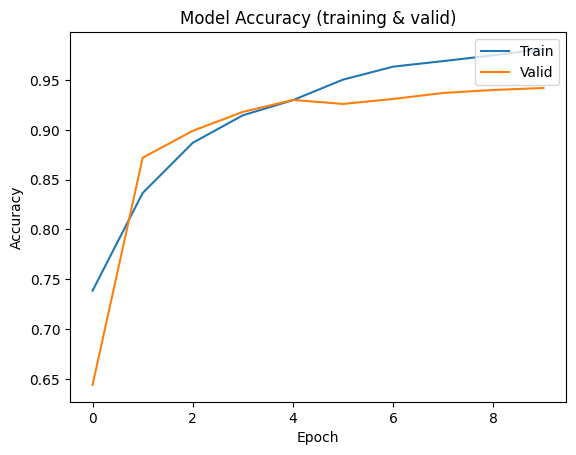

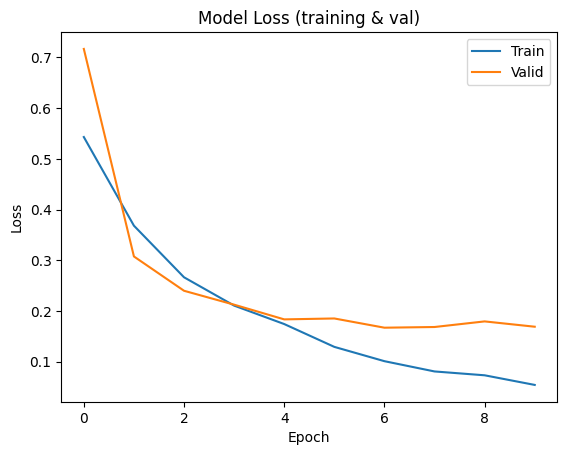

In [25]:
#InceptionResNetV2 accuracy graph

plt.plot(history_inc.history['accuracy'])
plt.plot(history_inc.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

plt.plot(history_inc.history['loss'])
plt.plot(history_inc.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [ ]:
#DenseNet-121 accuracy graph

plt.plot(history_dense.history['accuracy'])
plt.plot(history_dense.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

plt.plot(history_dense.history['loss'])
plt.plot(history_dense.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

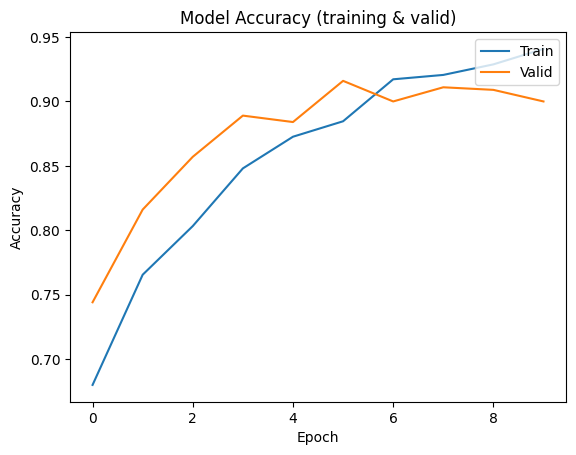

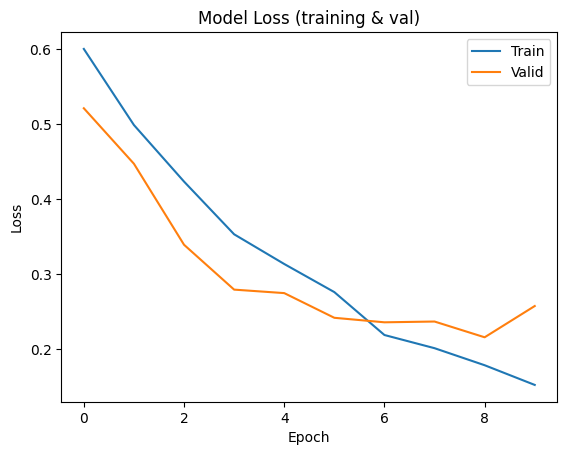

In [21]:
#VGG16 accuracy graph

plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Text(0.5, 1.0, 'This image is 96.25% Fake and 3.75% Real.')

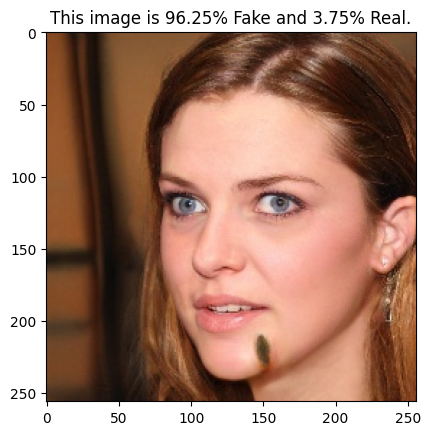

In [28]:
#fake test sample classification for InceptionResNetV2
test_image = tf.keras.preprocessing.image.load_img(r'C:\Users\ilfas\OneDrive\Documents\college\dm proj\df\df\real_vs_fake\real-vs-fake\test\fake\0AEIDNSBKD.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = inception_model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Text(0.5, 1.0, 'This image is 99.66% Fake and 0.34% Real.')

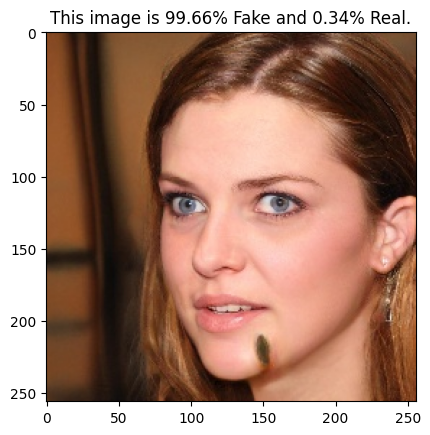

In [31]:
#fake test sample classification for DenseNet-121
test_image = tf.keras.preprocessing.image.load_img(r'C:\Users\ilfas\OneDrive\Documents\college\dm proj\df\df\real_vs_fake\real-vs-fake\test\fake\0AEIDNSBKD.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = dense_model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


Text(0.5, 1.0, 'This image is 85.19% Fake and 14.81% Real.')

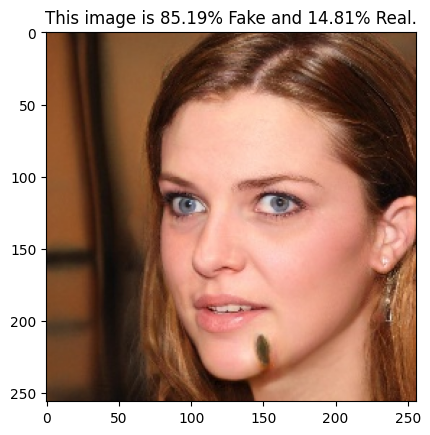

In [22]:
#fake test sample classification for VGG16
test_image = tf.keras.preprocessing.image.load_img(r'C:\Users\ilfas\OneDrive\Documents\college\dm proj\df\df\real_vs_fake\real-vs-fake\test\fake\0AEIDNSBKD.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = vgg_model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Text(0.5, 1.0, 'This image is 0.01% Fake and 99.99% Real.')

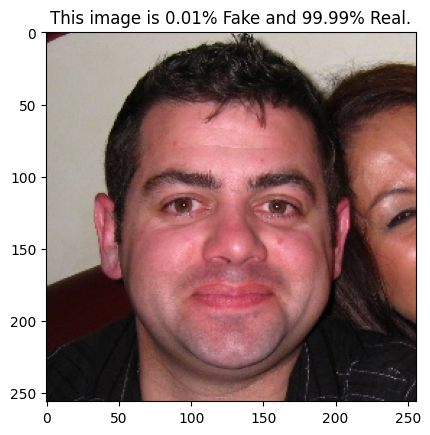

In [34]:
#real test sample classification for InceptionResNetV2
test_image = tf.keras.preprocessing.image.load_img(r'C:\Users\ilfas\OneDrive\Documents\college\dm proj\df\df\real_vs_fake\real-vs-fake\test\real\00016.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = dense_model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Text(0.5, 1.0, 'This image is 3.67% Fake and 96.33% Real.')

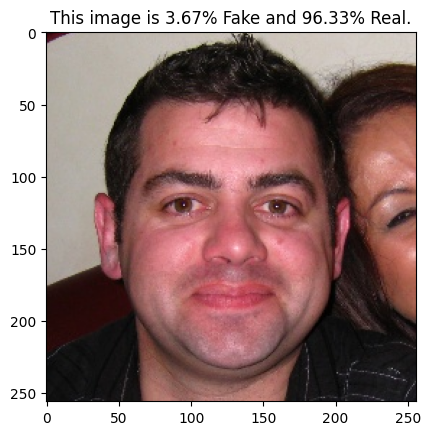

In [32]:
#real test sample classification for DenseNet-121
test_image = tf.keras.preprocessing.image.load_img(r'C:\Users\ilfas\OneDrive\Documents\college\dm proj\df\df\real_vs_fake\real-vs-fake\test\real\00016.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = dense_model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Text(0.5, 1.0, 'This image is 13.00% Fake and 87.00% Real.')

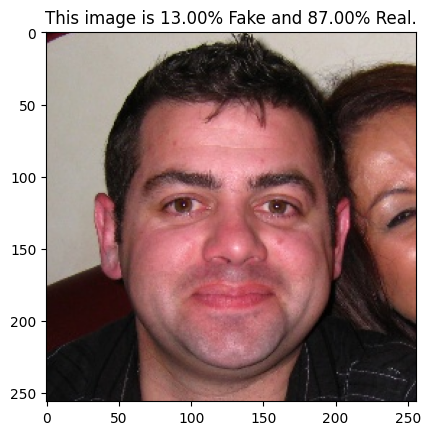

In [34]:
#real test sample classification for VGG16
test_image = tf.keras.preprocessing.image.load_img(r'C:\Users\ilfas\OneDrive\Documents\college\dm proj\df\df\real_vs_fake\real-vs-fake\test\real\00016.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = vgg_model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

In [35]:
# DenseNet-121 Predictions 
predicted_labels = dense_model.predict(test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


In [ ]:
# InceptionResNet-121 Predictions 
predicted_labels = inception_model.predict(test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step


In [24]:
# VGG16 Predictions 
predicted_labels = vgg_model.predict(test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step


In [25]:
# true labels
true_labels = test_ds.classes

In [35]:
# InceptionResNet-121 Classification Report 
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels.round())
print(report)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       500
           1       0.92      0.95      0.94       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [37]:
# Densenet-121 classification report
predicted_labels = dense_model.predict(test_ds)
true_labels = test_ds.classes
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels.round())
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       500
           1       0.94      0.97      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [26]:
# VGG16 classification report
predicted_labels = vgg_model.predict(test_ds)
true_labels = test_ds.classes
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels.round())
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       500
           1       0.90      0.92      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



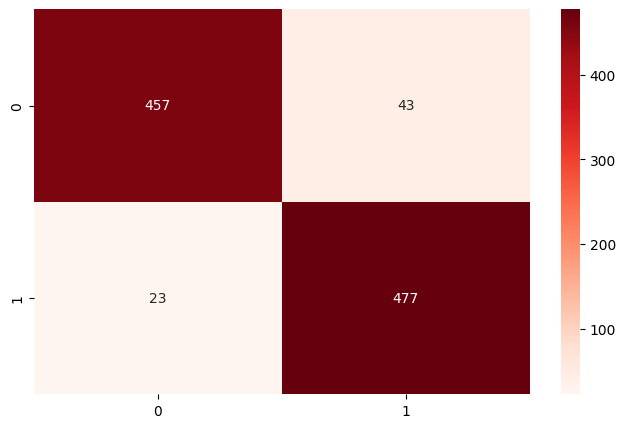

In [41]:
# InceptionResNet-121 Confusion Matrix
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Reds")
plt.show()


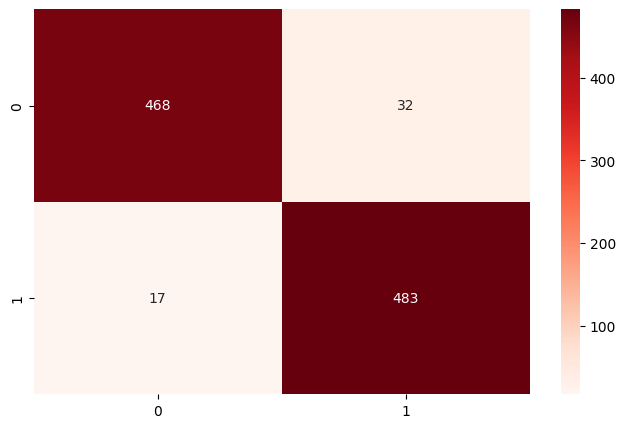

In [36]:
# Densenet-121 Confusion Matrix
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Reds")
plt.show()

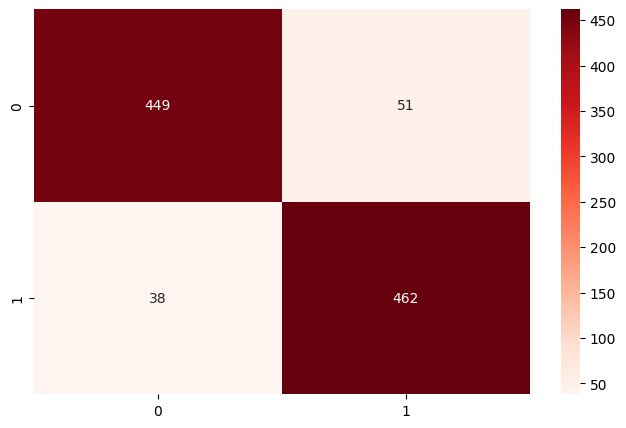

In [28]:
# VGG16 Confusion Matrix
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Reds")
plt.show()


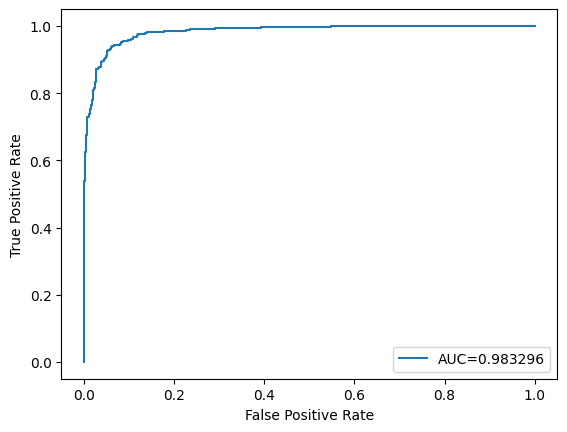

In [42]:
# InceptionResNet-121 ROC-AUC Curve
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

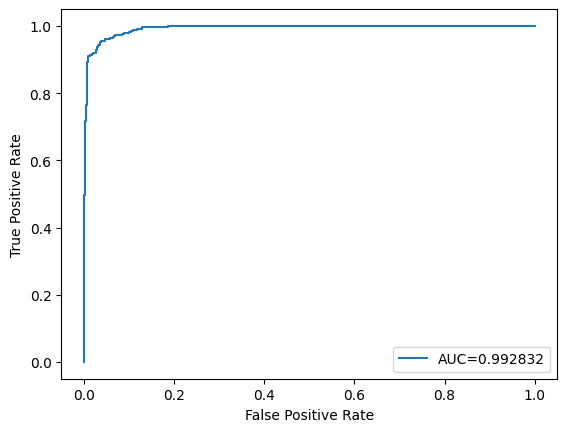

In [37]:
# DenseNet-121 ROC-AUC Curve
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

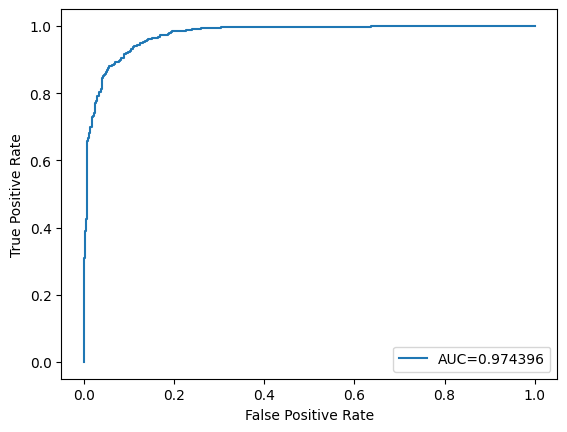

In [29]:
# VGG16 ROC-AUC Curve
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()